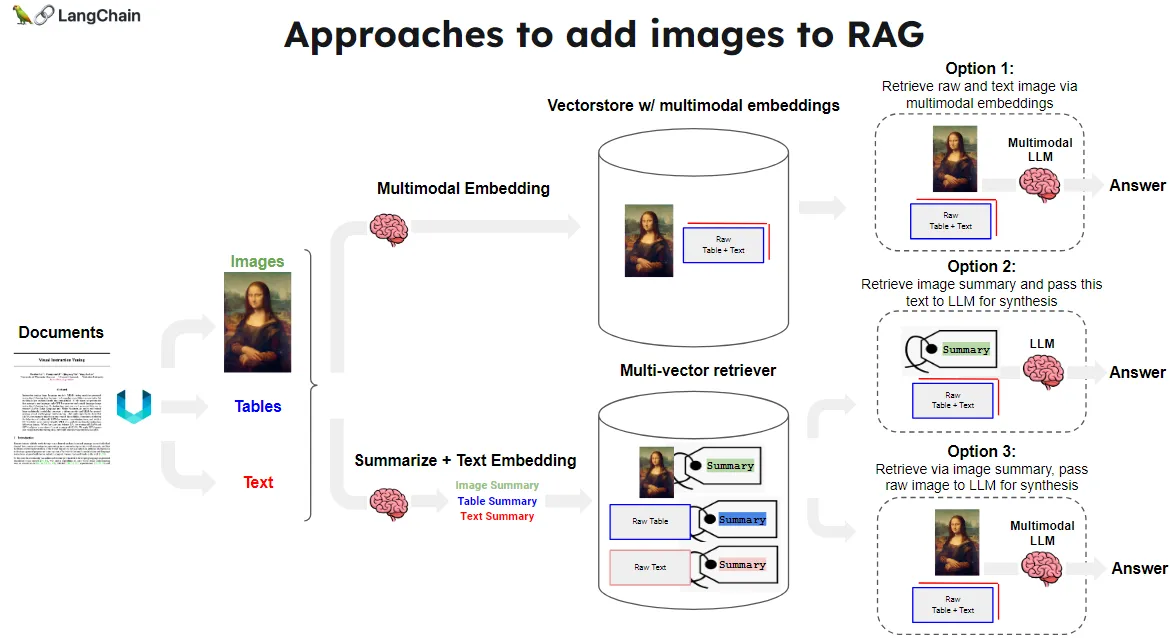

In [ ]:
# Requirements:

!pip install langchain unstructured[all-docs] pydantic lxml openai chromadb tiktoken pytesseract

In [1]:
import os
from unstructured.partition.pdf import partition_pdf
import pytesseract
import uuid

from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma

import base64
from langchain.chat_models import ChatOpenAI
from langchain.schema.messages import HumanMessage, AIMessage
from dotenv import load_dotenv

from langchain.schema.runnable import RunnablePassthrough
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

load_dotenv()

False

In [50]:
os.environ["OPENAI_API_KEY"]=openai_api_key

In [2]:
# pytesseract.pytesseract.tesseract_cmd = r'Downloads\Untitled Folder\tesseract.exe'

In [8]:
input_path = os.getcwd()
output_path = os.path.join(os.getcwd(), "figures")

raw_pdf_elements = partition_pdf(
    filename=os.path.join(input_path, "finstatements.pdf"),
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=output_path,
)

In [51]:
raw_pdf_elements

In [9]:
text_elements = []
table_elements = []
image_elements = []

def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode('utf-8')

for element in raw_pdf_elements:
    if 'CompositeElement' in str(type(element)):
        text_elements.append(element)
    elif 'Table' in str(type(element)):
        table_elements.append(element)

table_elements = [i.text for i in table_elements]
text_elements = [i.text for i in text_elements]

# Tables
print("The length of table elements are :", len(table_elements))

# Text
print("The length of text elements are :", len(text_elements))

for image_file in os.listdir(output_path):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):
        image_path = os.path.join(output_path, image_file)
        encoded_image = encode_image(image_path)
        image_elements.append(encoded_image)
        
# image
print("The length of image elements are :",len(image_elements))

The length of table elements are : 4
The length of text elements are : 12
The length of image elements are : 7


In [11]:
chain_gpt= ChatOpenAI(model="gpt-4o")

/var/folders/g9/yv_1sdqd0vd56ngr9s95zf6r0000gn/T/ipykernel_3259/2736359644.py:1: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  chain_gpt= ChatOpenAI(model="gpt-4o")


In [54]:
# table_elements

In [12]:
# def summarize_text(text_element):
#     prompt = f"Summarize the following text:\n\n{text_element}\n\nSummary:"
#     response = chain_gpt.invoke([HumanMessage(content=prompt)])
#     return response.content

# def summarize_table(table_element):
#     prompt = f"Summarize the following table:\n\n{table_element}\n\nSummary:"
#     response = chain_gpt.invoke([HumanMessage(content=prompt)])
#     return response.content

def summarize_image(encoded_image):
    prompt = [
        AIMessage(content="You are a bot that is good at analyzing images."),
        HumanMessage(content=[
            {"type": "text", "text": "Describe the contents of this image."},
            {
                "type": "image_url",
                "image_url": {
                    "url": f"data:image/jpeg;base64,{encoded_image}"
                },
            },
        ])
    ]
    response = chain_gpt.invoke(prompt)
    return response.content

In [14]:
# text_summaries=[summarize_text(i) for i in text_elements]
# table_summaries=[summarize_table(i) for i in table_elements]
image_summaries=[summarize_image(i) for i in image_elements]

In [56]:
# image_summaries

In [20]:
vectorstore = Chroma(collection_name="summaris", embedding_function=OpenAIEmbeddings())
store = InMemoryStore()
id_key = "doc_id"
retriever = MultiVectorRetriever(vectorstore=vectorstore, docstore=store, id_key=id_key,top_k=1)

/var/folders/g9/yv_1sdqd0vd56ngr9s95zf6r0000gn/T/ipykernel_3259/2420423077.py:1: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  vectorstore = Chroma(collection_name="summaris", embedding_function=OpenAIEmbeddings())
/var/folders/g9/yv_1sdqd0vd56ngr9s95zf6r0000gn/T/ipykernel_3259/2420423077.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vectorstore = Chroma(collection_name="summaris", e

In [21]:
def add_documents_to_retriever(summaries, original_contents):
    doc_ids = [str(uuid.uuid4()) for _ in summaries]
    summary_docs = [
        Document(page_content=s, metadata={id_key: doc_ids[i]})
        for i, s in enumerate(summaries)
    ]
    retriever.vectorstore.add_documents(summary_docs)
    retriever.docstore.mset(list(zip(doc_ids, original_contents)))


# Add text summaries
add_documents_to_retriever(text_elements, text_elements)

# Add table summaries
add_documents_to_retriever(table_elements, table_elements)

# Add image summaries
add_documents_to_retriever(image_summaries, image_elements) 

In [27]:
template = """Answer the question based only on the following context, which can include text, images and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# model = ChatOpenAI(temperature=0, model="gpt-4o")

chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)
question= "Overview of the Financial Statements"
answer = chain.invoke(question)
print(answer)

The financial statements prepared in accordance with IPSAS for the Organization include the following:

1. **Statement of Financial Position**: This statement details the net assets, which is the difference between total assets and total liabilities. It provides information about the financial strength of the Organization and the resources available to support its future objectives.

2. **Statement of Financial Performance**: This measures the net surplus or deficit, which is the difference between total revenue and total expenses for the year. It provides information on the Organization’s sources of revenue and the cost of its activities. The annual surplus or deficit is presented on a full accrual basis of accounting, recognizing revenue in the period it is earned and expenses when incurred.

3. **Statement of Changes in Net Assets**: This statement identifies the change in the net asset position during the year, highlighting the sources of changes in the Organization’s overall finan

In [57]:
ret = chain.first
contexts=ret.invoke("Overview of the Financial Statements")["context"]
contexts

['Financial Statement Highlights\n\nThe financial statements prepared in accordance with IPSAS consist of:\n\nStatement of Financial Position - details the net assets (the difference between total assets and total liabilities) of the Organization. This statement provides information about the financial strength of the Organization, and the resources which are available to support its future objectives;\n\nStatement of Financial Performance - measures the net surplus or deficit (the difference between total revenue and total expenses) for the year. This statement provides information on the Organization’s sources of revenue, and the cost of its activities. The annual surplus or deficit is presented on a full accrual basis of accounting, recognizing revenue in the period it is earned and expenses when incurred, regardless of when the associated cash is received or paid;\n\nStatement of Changes in Net Assets - identifies the change in the net asset position during the year. This statement

In [59]:
ret = chain.first
contexts=ret.invoke("USD – Comparison of PCT equivalent amount rate and UNORE 2012-2016")["context"]
contexts

['10\n\nWIPO ANNUAL FINANCIAL REPORT AND FINANCIAL STATEMENTS 2016\n\nUSD – Comparison of PCT equivalent amount rate and UNORE 2012-2016\n\n1.04 1.02 1.00 0.98 0.96 0.94 0.92 0.90 0.88 Dec-11 Jun-12 Dec-12 Jun-13 Dec-13 Jun-14 Dec-14 Jun-15 Dec-15 Jun-16 Dec-16\n\n—— USD Fee rates ——— USD UNORE rates\n\nJPY – Comparison of PCT equivalent amount rate and UNORE 2012-2016\n\n0.013 0.012 0.011 0.010 0.009 0.008 0.007 Dec-11 Jun-12 Dec-12 Jun-13 Dec-13 Jun-14 Dec-14 Jun-15 Dec-15 Jun-16 Dec-16\n\n—— JPY Fee rates ——— JPY UNORE rates\n\nEUR – Comparison of PCT equivalent amount rate and UNORE 2012-2016\n\n1.270 1.220 1.170 1.120 1.070 1.020 Dec-11 Jun-12 Dec-12 Jun-13 —— EUR Fee rates Dec-13 Jun-14 Dec-14 Jun-15 ———— EUR UNORE rates Dec-15 Jun-16 Dec-16\n\n11',
 'Detail of exchange gain/(loss) on PCT fees received 2012-2016',
 '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMj

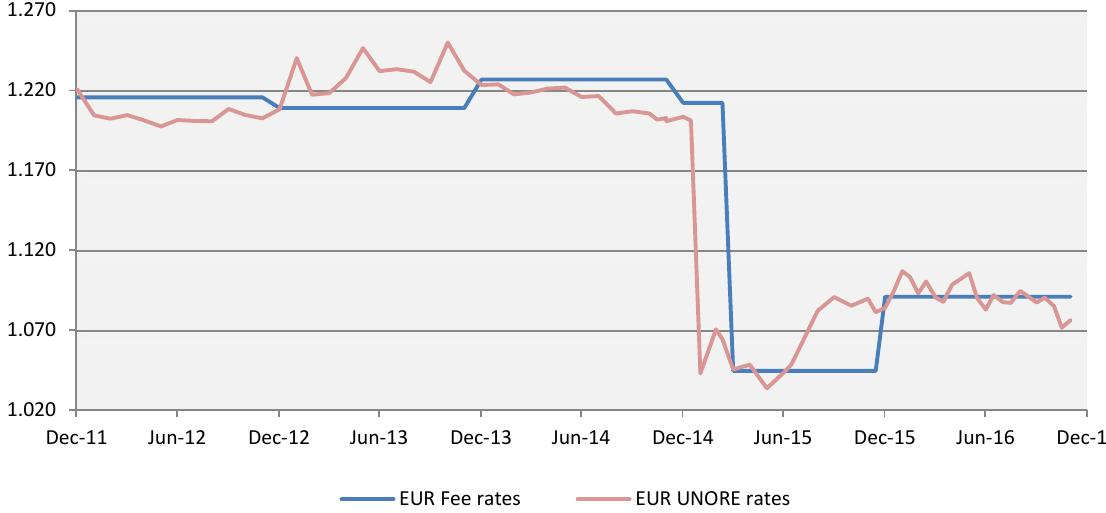

In [62]:
import base64
from PIL import Image
from io import BytesIO
import IPython.display as display

def display_encoded_image(encoded_string):
    # Decode the base64 string
    image_data = base64.b64decode(encoded_string)
    
    # Create an image object from the binary data
    image = Image.open(BytesIO(image_data))
    
    # Display the image in the Jupyter Notebook
    display.display(image)

# Example usage
encoded_image = "..."  # Replace with the base64-encoded string
display_encoded_image(contexts[2])


In [360]:
ground_truth = "MLOps works by introducing a set of practices that support machine learning models throughout their lifecycle, similar to how DevOps addresses issues in software engineering. It enables data scientists, ML engineers, and app developers to collaborate effectively, focusing on delivering value to customers. MLOps involves packaging modeling code, dependencies, and runtime requirements to ensure reproducibility, which reduces the costs of packaging and maintaining model versions. This approach facilitates easier deployment at scale and provides a structured methodology for validation, deployment, monitoring, and governance. By implementing MLOps, organizations can achieve faster deployment times, create reusable components, automate processes, and ensure compliance and governance, ultimately leading to a more efficient and scalable AI/ML model implementation."

In [20]:
from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI
from langchain.embeddings import OpenAIEmbeddings

In [103]:
from ragas.metrics import (answer_relevancy,faithfulness,answer_correctness,answer_similarity,context_precision,context_recall)
from ragas import evaluate

In [30]:
import pandas as pd
from datasets import Dataset

In [32]:
from langchain_nvidia_ai_endpoints import ChatNVIDIA

client = ChatNVIDIA(
  model="mistralai/mixtral-8x7b-instruct-v0.1",
  api_key="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", 
  temperature=0.5,
  top_p=1,
  max_tokens=1024,
)

In [33]:
evaluator_llm = LangchainLLMWrapper(client)
evaluator_embeddings = LangchainEmbeddingsWrapper(OpenAIEmbeddings())

In [225]:
data = {
    'query': question,
    'ground_truths': ground_truth,
    'generated_answer': answer,
    'retrieved_contexts': contexts
}

In [235]:
dff = pd.DataFrame({
    "user_input": data["query"],  
    "retrieved_contexts": [data["retrieved_contexts"]],
    "ground_truths": [data["ground_truths"]],
    "response": data["generated_answer"],  
    "reference": [data["ground_truths"]]  
})
df2 = Dataset.from_pandas(dff)

In [237]:
df2

Dataset({
    features: ['user_input', 'retrieved_contexts', 'ground_truths', 'response', 'reference'],
    num_rows: 1
})

In [236]:
resultss = evaluate(dataset=df2,llm =evaluator_llm, embeddings=evaluator_embeddings, metrics=[answer_relevancy,faithfulness,answer_correctness,answer_similarity,context_precision,context_recall])
resultss

Evaluating:   0%|          | 0/6 [00:00<?, ?it/s]

Exception raised in Job[2]: APIConnectionError(Connection error.)
Exception raised in Job[3]: APIConnectionError(Connection error.)


{'answer_relevancy': 0.9128, 'faithfulness': 1.0000, 'answer_correctness': nan, 'semantic_similarity': nan, 'context_precision': 1.0000, 'context_recall': 0.8000}

In [238]:
df = resultss.to_pandas()
df.head()

,user_input,retrieved_contexts,response,reference,answer_relevancy,faithfulness,answer_correctness,semantic_similarity,context_precision,context_recall
0,How does MLOps work?,[4\n\nThese benefits put organizations with ML...,MLOps works by introducing a set of practices ...,MLOps works by introducing a set of practices ...,0.912829,1.0,NaN,NaN,1.0,0.8


In [239]:
resultss = evaluate(dataset=df2, llm=evaluator_llm, embeddings=evaluator_embeddings, metrics=[answer_similarity])
print(resultss)

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Exception raised in Job[0]: APIConnectionError(Connection error.)


{'semantic_similarity': nan}


In [240]:
resultss = evaluate(dataset=df2, llm=evaluator_llm, embeddings=evaluator_embeddings, metrics=[answer_correctness])
print(resultss)

Evaluating:   0%|          | 0/1 [00:00<?, ?it/s]

Exception raised in Job[0]: APIConnectionError(Connection error.)


{'answer_correctness': nan}


In [288]:
import nltk
from nltk.translate.meteor_score import meteor_score

In [292]:
reference = ground_truth  
generated = answer  

meteor = meteor_score([reference.split()], generated.split())  
print(f"METEOR Score: {meteor:.4f}")

METEOR Score: 1.0000


In [290]:
reference_tokens = nltk.word_tokenize(reference.lower())
generated_tokens = nltk.word_tokenize(generated.lower())

reference_set = set(reference_tokens)
generated_set = set(generated_tokens)

In [293]:
# Calculate True Positives (correct matches), False Positives, and False Negatives
tp = len(reference_set.intersection(generated_set))  
fp = len(generated_set - reference_set)              
fn = len(reference_set - generated_set)              

# Precision, Recall, and F1 Score calculations
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [190]:
from bert_score import BERTScorer

In [192]:
reference = answer
candidate = ground_truth

In [193]:
scorer = BERTScorer(model_type='bert-base-uncased')
P, R, F1 = scorer.score([candidate], [reference])
print(f"BERTScore Precision: {P.mean():.4f}, Recall: {R.mean():.4f}, F1: {F1.mean():.4f}")

BERTScore Precision: 1.0000, Recall: 1.0000, F1: 1.0000


In [159]:
import mlflow
import openai
import os
import pandas as pd
import dagshub

dagshub.init(repo_owner='priyanshusingh8518', repo_name='my-first-repo', mlflow=True)
mlflow.set_tracking_uri("https://dagshub.com/priyanshusingh8518/my-first-repo.mlflow")

eval_data = pd.DataFrame(
    {
        "inputs": [
            "What is MLflow?",
            "What is Spark?",
        ],
        "ground_truth": [
            "MLflow is an open-source platform for managing the end-to-end machine learning (ML) "
            "lifecycle. It was developed by Databricks, a company that specializes in big data and "
            "machine learning solutions. MLflow is designed to address the challenges that data "
            "scientists and machine learning engineers face when developing, training, and deploying "
            "machine learning models.",
            "Apache Spark is an open-source, distributed computing system designed for big data "
            "processing and analytics. It was developed in response to limitations of the Hadoop "
            "MapReduce computing model, offering improvements in speed and ease of use. Spark "
            "provides libraries for various tasks such as data ingestion, processing, and analysis "
            "through its components like Spark SQL for structured data, Spark Streaming for "
            "real-time data processing, and MLlib for machine learning tasks",
        ],
    }
)

mlflow.set_experiment("LLM Evaluation")

with mlflow.start_run() as run:
    system_prompt = "Answer the following question in two sentences"
    # Wrap "gpt-4" as an MLflow model.
    logged_model_info = mlflow.openai.log_model(
        model="gpt-4",
        task=openai.chat.completions,
        artifact_path="model",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": "{question}"},
        ],
    )

    # Configure column mapping for evaluation
    evaluator_config = {
        'col_mapping': {'context': 'inputs'}
    }

    # Use predefined question-answering metrics to evaluate our model.
    results = mlflow.evaluate(
        logged_model_info.model_uri,
        eval_data,
        targets="ground_truth",
        model_type="question-answering",
        extra_metrics=[
            mlflow.metrics.genai.answer_correctness(),
            mlflow.metrics.genai.answer_relevance(),
            mlflow.metrics.genai.faithfulness()
        ],
        evaluator_config=evaluator_config
    )

    print(f"See aggregated evaluation results below: \n{results.metrics}")

    # Evaluation result for each data record is available in `results.tables`.
    eval_table = results.tables["eval_results_table"]
    df = pd.DataFrame(eval_table)
    df.to_csv('eval.csv')
    print(f"See evaluation table below: \n{eval_table}")


Initialized MLflow to track repo "priyanshusingh8518/my-first-repo"

Repository priyanshusingh8518/my-first-repo initialized!

2024/11/11 15:11:54 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/11/11 15:11:57 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/11/11 15:11:57 WARNING mlflow.metrics.metric_definitions: Failed to load 'toxicity' metric (error: ModuleNotFoundError("No module named 'evaluate'")), skipping metric logging.
2024/11/11 15:11:57 WARNING mlflow.models.evaluation.default_evaluator: Did not log builtin metric 'toxicity' because it returned None.
2024/11/11 15:11:57 WARNING mlflow.metrics.metric_definitions: Failed to import textstat for flesch kincaid metric, skipping metric logging. Please install textstat using 'pip install textstat'.
2024/11/11 15:11:57 WARNING mlflow.models.evaluation.default_evaluator: Did not log builtin metric 'flesch_kincaid_grade_level' because it returned None.
2024/11/11 15:11:57 WARNING mlflow.metrics.metric_definitions: Failed to import textstat for automated readability index metric, skippi

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

2024/11/11 15:12:09 WARNING mlflow.metrics.metric_definitions: Failed to load 'toxicity' metric (error: ModuleNotFoundError("No module named 'evaluate'")), skipping metric logging.
2024/11/11 15:12:09 WARNING mlflow.models.evaluation.default_evaluator: Did not log builtin metric 'toxicity' because it returned None.
2024/11/11 15:12:09 WARNING mlflow.metrics.metric_definitions: Failed to import textstat for flesch kincaid metric, skipping metric logging. Please install textstat using 'pip install textstat'.
2024/11/11 15:12:09 WARNING mlflow.models.evaluation.default_evaluator: Did not log builtin metric 'flesch_kincaid_grade_level' because it returned None.
2024/11/11 15:12:09 WARNING mlflow.metrics.metric_definitions: Failed to import textstat for automated readability index metric, skipping metric logging. Please install textstat using 'pip install textstat'.
2024/11/11 15:12:09 WARNING mlflow.models.evaluation.default_evaluator: Did not log builtin metric 'ari_grade_level' because i

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

See aggregated evaluation results below: 
{'exact_match/v1': 0.0, 'answer_correctness/v1/mean': 4.5, 'answer_correctness/v1/variance': 0.25, 'answer_correctness/v1/p90': 4.9, 'answer_relevance/v1/mean': 5.0, 'answer_relevance/v1/variance': 0.0, 'answer_relevance/v1/p90': 5.0, 'faithfulness/v1/mean': 3.0, 'faithfulness/v1/variance': 4.0, 'faithfulness/v1/p90': 4.6}


See evaluation table below: 
            inputs                                       ground_truth  \
0  What is MLflow?  MLflow is an open-source platform for managing...   
1   What is Spark?  Apache Spark is an open-source, distributed co...   

                                             outputs  token_count  \
0  MLflow is an open-source platform designed to ...           46   
1  Spark is an open-source, distributed computing...           32   

   answer_correctness/v1/score  \
0                            5   
1                            4   

                 answer_correctness/v1/justification  \
0  The output provided by the model is correct. I...   
1  The output provided by the model is mostly cor...   

   answer_relevance/v1/score  \
0                          5   
1                          5   

                   answer_relevance/v1/justification  faithfulness/v1/score  \
0  The output directly addresses the input questi...                      5   
1  The output di

2024/11/11 15:12:38 INFO mlflow.tracking._tracking_service.client: 🏃 View run fortunate-bear-658 at: https://dagshub.com/priyanshusingh8518/my-first-repo.mlflow/#/experiments/0/runs/7091060c3c864d938ff850b790db7521.
2024/11/11 15:12:38 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://dagshub.com/priyanshusingh8518/my-first-repo.mlflow/#/experiments/0.
